# MOM6 ANALYSIS - Eddy Shedding
Here I'm starting the investigation of Eddy Shedding within the EAC Separation region. This is in an effort to present at the PO meeting next week, however I wanted to leave the model evaluation presentation to a future COSIMA meeting rather than the PO Meeting. 

In this notebook I aim to look at the eddy kinetic energy (EKE) in the separation region, and how this might relate to changes in mean kinetic energy (MKE) further north, as well as available potential energy (APE) further north as well. I'd like to look at ways to approximate the eddy energy conversion terms (i.e., barotropic/baroclinic instability pathways) and also consider filtering the data to extract the mesoscale frequencies of interest. 

### 1. Load in data and subset in space around the EAC Separation site

In [1]:
import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np
import glob
import xesmf

In [2]:
# import climtas

In [3]:
from matplotlib import patches
import cartopy.feature as cfeature
import matplotlib.lines as mlines
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [4]:
from xgcm import Grid

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [5]:
# import cartopy to plot maps
import cartopy.crs as ccrs
import cartopy.feature as feature
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m', 
                                       edgecolor='black',
                                       facecolor='gray',
                                       linewidth=0.2)

In [6]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33013/status,
Dashboard: /proxy/33013/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46509,Workers: 4
Dashboard: /proxy/33013/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:38539,Total threads: 1
Dashboard: /proxy/41141/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:32789,


In [7]:
# set paths to model output
## SRM
# eac_003 = '/scratch/v45/jr5971/mom6/archive/eac-003-latest/'
eac_003 = '/scratch/v45/jr5971/mom6-setonix/eac_iaf_003/'
## LRM
sthpac_01 = '/scratch/v45/jr5971/mom6-setonix/sthpac_iaf_01/'
## PARENT
access = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/'
## EAC MOORING 
eac_mooring = '/scratch/v45/jr5971/eac-mooring/'

In [8]:
# import os
# os.chdir('/home/581/jr5971/jr5971/notebooks/')
# # from custom_funcs import *
from myfuncs import *

## Contents

### 1. ACCESS-OM2 EKE calcs

In [10]:
# get velocities

om2_iaf, _ = open_iaf_global(input_vars=['eta'],
                             first_year=1990, last_year=2020,
                            decode_times=True)
om2_iaf

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 300. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 300. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 300. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

<xarray.Dataset>
Dimensions:     (xt_ocean: 3600, yt_ocean: 2700, time: 10957, nv: 2)
Coordinates:
  * xt_ocean    (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean    (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time        (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:0...
  * nv          (nv) float64 1.0 2.0
Data variables:
    eta_t       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(90, 300, 300), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(90, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-2d-eta_t-1-daily-mean-ym_1990_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221019T1330Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

(-220.0, -194.0)

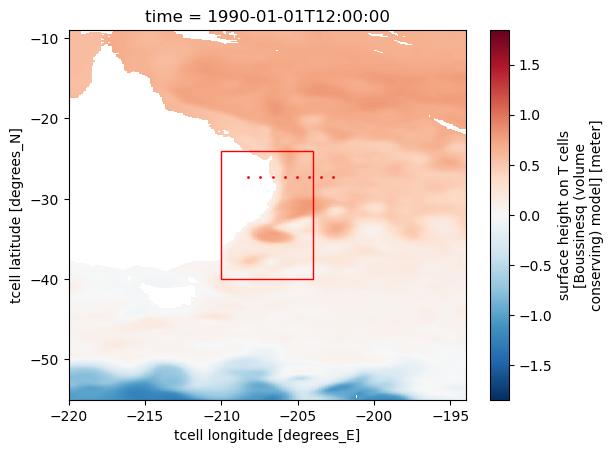

In [13]:
# Select u,v and subset to same domain as 'eac_eddy' 
eddy_idx = {'W':-210, 'E':-204, 'S':-40, 'N':-24}
eac_mooring = {'lon':[153.771-360, 155.3-360], 'lat':-27.3}
mooring_ext = {'lon':[eac_mooring['lon'][0]-2, eac_mooring['lon'][1]+2], 'lat':-27.3}

# Quick plot to show the rough location...
fig, ax = plt.subplots()
om2_iaf['eta_t'].isel(time=0).plot(ax=ax)
eddy_box = patches.Rectangle((eddy_idx['W'], eddy_idx['S']), (eddy_idx['E']-eddy_idx['W']),
                             (eddy_idx['N']-eddy_idx['S']), color='r', fill=None)

array = np.linspace(mooring_ext['lon'][0], mooring_ext['lon'][1], 8)
ax.scatter(array, [eac_mooring['lat']]*len(array), color='r', marker='o', s=1)

# ax.scatter(x=np.linspace(mooring_ext['lon'][0], mooring_ext['lon'][1], 8),y=mooring_ext['lat']*7, color='r', marker='o', s=1)
ax.axhline(y=mooring_ext['lat'], xmin=mooring_ext['lon'][0], xmax=mooring_ext['lon'][1], zorder=3, color='r')
ax.add_patch(eddy_box)
ax.set_ylim(eddy_idx['S']-15, eddy_idx['N']+15)
ax.set_xlim(eddy_idx['W']-10, eddy_idx['E']+10)

In [14]:
# get subset of eta
eta_om2 = om2_iaf['eta_t'].sel(xt_ocean=slice(eddy_idx['W'], eddy_idx['E']), 
                               yt_ocean=slice(eddy_idx['S'], eddy_idx['N']))
eta_om2_chunked = eta_om2.chunk({'time':'auto', 'xt_ocean':-1, 'yt_ocean':-1})
eta_om2_chunked.data

dask.array<rechunk-merge, shape=(10957, 190, 60), dtype=float32, chunksize=(2852, 190, 60), chunktype=numpy.ndarray>

In [15]:
%%time
eta_om2_chunked.to_netcdf('/g/data/v45/jr5971/notebooks/data/eta_om2.nc')

CPU times: user 13.4 s, sys: 2.25 s, total: 15.7 s
Wall time: 3min 38s


2023-12-04 17:30:07,001 - distributed.nanny - WARNING - Restarting worker
2023-12-04 17:30:07,030 - distributed.nanny - WARNING - Restarting worker
2023-12-04 17:30:07,089 - distributed.nanny - WARNING - Restarting worker
2023-12-04 17:30:07,096 - distributed.nanny - WARNING - Restarting worker
2023-12-04 17:30:07,393 - distributed.nanny - WARNING - Restarting worker
2023-12-04 17:30:07,395 - distributed.nanny - WARNING - Restarting worker
2023-12-04 17:30:08,398 - distributed.nanny - WARNING - Restarting worker
2023-12-04 17:30:08,402 - distributed.nanny - WARNING - Restarting worker


In [33]:
%%time
# Subset om2 velocities to eac_eddy box 
## Choose just surface values 
v_om2 = om2_iaf['v'].sel(xu_ocean=slice(eddy_idx['W'], eddy_idx['E']), 
                         yu_ocean=slice(eddy_idx['S'], eddy_idx['N'])).isel(st_ocean=0)
                         # st_ocean=slice(0, 500)).sum('st_ocean')#.compute()
u_om2 = om2_iaf['u'].sel(xu_ocean=slice(eddy_idx['W'], eddy_idx['E']), 
                         yu_ocean=slice(eddy_idx['S'], eddy_idx['N'])).isel(st_ocean=0)
                         # st_ocean=slice(0, 500)).sum('st_ocean')#.compute()

CPU times: user 9.02 ms, sys: 0 ns, total: 9.02 ms
Wall time: 8.65 ms


In [14]:
# Rechunk data
v_om2_chunked = v_om2.chunk({'time':'auto', 'xu_ocean':-1, 'yu_ocean':-1})
u_om2_chunked = u_om2.chunk({'time':'auto', 'xu_ocean':-1, 'yu_ocean':-1})
u_om2_chunked.data

dask.array<rechunk-merge, shape=(10957, 190, 60), dtype=float32, chunksize=(2914, 190, 60), chunktype=numpy.ndarray>

In [15]:
%%time
# Compute the velocities
u_om2_computed = u_om2_chunked.compute()
v_om2_computed = v_om2_chunked.compute()

CPU times: user 1min 12s, sys: 14 s, total: 1min 26s
Wall time: 8min 50s


In [10]:
u = xr.open_dataarray('/g/data/v45/jr5971/notebooks/data/u_om2_z30_eac.nc')
v = xr.open_dataarray('/g/data/v45/jr5971/notebooks/data/v_om2_z30_eac.nc')
u

<xarray.DataArray 'u' (time: 10957, yu_ocean: 190, xu_ocean: 60)>
[124909800 values with dtype=float32]
Coordinates:
  * xu_ocean  (xu_ocean) float64 -210.0 -209.9 -209.8 ... -204.3 -204.2 -204.1
  * yu_ocean  (yu_ocean) float64 -39.99 -39.91 -39.84 ... -24.24 -24.15 -24.06
    st_ocean  float64 ...
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  sea_water_x_velocity

In [11]:
%%time
# Calculate mean velocities across the eddy box
v_om2_mean = v.mean('time')#.compute()
u_om2_mean = u.mean('time')#.compute()
# Calculate transient velocities
v_om2_transient = v - v_om2_mean
u_om2_transient = u - u_om2_mean

CPU times: user 9.17 s, sys: 2.24 s, total: 11.4 s
Wall time: 11.7 s


In [12]:
# Calculate EKE
EKE_om2 = (0.5 * (u_om2_transient**2 + v_om2_transient**2))#.compute()
EKE_om2

<xarray.DataArray (time: 10957, yu_ocean: 190, xu_ocean: 60)>
array([[[1.07357102e-02, 1.01166200e-02, 9.30453651e-03, ...,
         1.37928296e-02, 1.78901926e-02, 1.86305419e-02],
        [1.03588914e-02, 9.63680167e-03, 8.56501702e-03, ...,
         1.47418510e-02, 1.71798542e-02, 1.71113200e-02],
        [9.56978183e-03, 9.06575844e-03, 7.88485073e-03, ...,
         1.51828052e-02, 1.74985956e-02, 1.75634846e-02],
        ...,
        [           nan,            nan,            nan, ...,
         1.30505323e-05, 9.33804695e-05, 2.42249022e-04],
        [           nan,            nan,            nan, ...,
         3.96744115e-04, 3.55897268e-04, 5.85332164e-04],
        [           nan,            nan,            nan, ...,
         9.33399017e-04, 4.19537188e-04, 1.39373518e-03]],

       [[1.47799496e-02, 1.46280695e-02, 1.35908779e-02, ...,
         6.38618087e-03, 6.62772032e-03, 6.10647444e-03],
        [1.32254753e-02, 1.31477164e-02, 1.23698553e-02, ...,
         7.40314927e-03, 8.17153044e-03, 8.35848041e-03],
        [1.17704272e-02, 1.18223466e-02, 1.11552663e-02, ...,
         9.16144252e-03, 1.06257759e-02, 1.13214888e-02],
...
        [           nan,            nan,            nan, ...,
         8.90704617e-03, 1.91983543e-02, 3.43676694e-02],
        [           nan,            nan,            nan, ...,
         4.60954290e-03, 1.43279703e-02, 2.88370978e-02],
        [           nan,            nan,            nan, ...,
         1.86811027e-03, 1.08409422e-02, 2.35278420e-02]],

       [[9.59638692e-03, 1.96150094e-02, 3.39791253e-02, ...,
         2.36135256e-02, 1.91198010e-02, 1.56867802e-02],
        [9.13627446e-03, 2.04035044e-02, 3.43184508e-02, ...,
         6.84543652e-03, 5.28066605e-03, 6.21922594e-03],
        [2.24146470e-02, 3.47842127e-02, 4.82508764e-02, ...,
         7.34085042e-04, 1.53757317e-03, 4.53768903e-03],
        ...,
        [           nan,            nan,            nan, ...,
         9.55959596e-03, 2.23126300e-02, 4.02230136e-02],
        [           nan,            nan,            nan, ...,
         4.52561118e-03, 1.51695553e-02, 3.16886380e-02],
        [           nan,            nan,            nan, ...,
         1.18671567e-03, 9.94806737e-03, 2.42159721e-02]]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -210.0 -209.9 -209.8 ... -204.3 -204.2 -204.1
  * yu_ocean  (yu_ocean) float64 -39.99 -39.91 -39.84 ... -24.24 -24.15 -24.06
    st_ocean  float64 29.45
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00

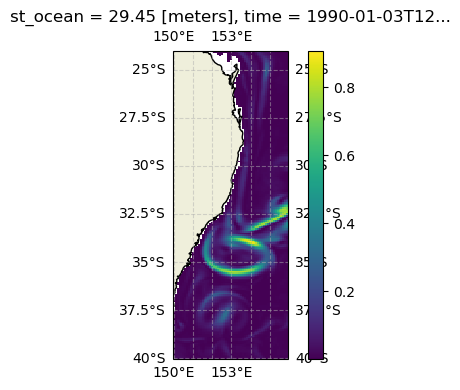

In [37]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))

EKE_om2.isel(time=2).plot(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')


In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [39]:
def plot_eac_eke(i):
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))
    EKE_om2.isel(time=i).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=0.6)
    ax.add_feature(cfeature.LAND)
    ax.coastlines()
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')

In [40]:
interact(plot_eac_eke, i=(0, len(EKE_om2.time),1))

interactive(children=(IntSlider(value=5478, description='i', max=10957), Output()), _dom_classes=('widget-inte…

<function __main__.plot_eac_eke(i)>

It would be great to make an interactive plot of the above, along with the relative vorticity. Below is parts of the example notebook from COSIMA written for the relative vorticity calculation in MOM5

### Vorticity Calculation

In [9]:
# Parameters used for computing quantities
Omega = 7.292e-5 # Earth's rotation rate in radian/s
Rearth = 6371.e3 # Earth's radius in m

In [10]:
lon = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output000/ocean/ocean-2d-geolon_c.nc')['geolon_c']
lat = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output000/ocean/ocean-2d-geolat_c.nc')['geolat_c']
lon

<xarray.DataArray 'geolon_c' (yu_ocean: 2700, xu_ocean: 3600)>
[9720000 values with dtype=float32]
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
Attributes:
    long_name:     uv longitude
    units:         degrees_E
    valid_range:   [-281.  361.]
    cell_methods:  time: point
    coordinates:   geolon_c geolat_c

In [11]:
# Calculate the Coriolis parameter f = 2*Omega*sin(lat)
f = 2 * Omega * np.sin(np.deg2rad(lat))
f.attrs['long_name'] = 'Coriolis Parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'

In [14]:
%%time
# Subset om2 velocities to eac_eddy box 
## Choose just surface values 
v_om2_z30 = om2_iaf['v'].sel(xu_ocean=slice(eddy_idx['W'], eddy_idx['E']), 
                         yu_ocean=slice(eddy_idx['S'], eddy_idx['N'])).sel(st_ocean=30, method='nearest')
                         # st_ocean=slice(0, 500)).sum('st_ocean')#.compute()
u_om2_z30 = om2_iaf['u'].sel(xu_ocean=slice(eddy_idx['W'], eddy_idx['E']), 
                         yu_ocean=slice(eddy_idx['S'], eddy_idx['N'])).sel(st_ocean=30, method='nearest')
                         # st_ocean=slice(0, 500)).sum('st_ocean')#.compute()

CPU times: user 26.2 ms, sys: 8.28 ms, total: 34.5 ms
Wall time: 61.5 ms


In [15]:
# Rechunk data
v_om2_z30_chunked = v_om2_z30.chunk({'time':'auto', 'xu_ocean':-1, 'yu_ocean':-1})
u_om2_z30_chunked = u_om2_z30.chunk({'time':'auto', 'xu_ocean':-1, 'yu_ocean':-1})
u_om2_z30_chunked.data

dask.array<rechunk-merge, shape=(10957, 190, 60), dtype=float32, chunksize=(2914, 190, 60), chunktype=numpy.ndarray>

In [16]:
%%time
# Compute the velocities
u_om2_z30_computed = u_om2_z30_chunked.compute()
v_om2_z30_computed = v_om2_z30_chunked.compute()

CPU times: user 1min 19s, sys: 16 s, total: 1min 35s
Wall time: 9min 18s


In [18]:
%%time
u_om2_z30_computed.to_netcdf('/g/data/v45/jr5971/notebooks/data/u_om2_z30_eac.nc')
v_om2_z30_computed.to_netcdf('/g/data/v45/jr5971/notebooks/data/v_om2_z30_eac.nc')


CPU times: user 28.9 s, sys: 1.28 s, total: 30.2 s
Wall time: 29.7 s


#### Method 1 (naive computation)
To compute relative vorticity $\zeta=\partial_xv - \partial_yu$, we simply differentiate the velocity components with respect to lon/lat. We then convert the derivatives from units of degrees-1 to m-1. To do so, we use the value of the radius of the Earth (`Rearth`) and also take into account that as we go towards the poles, the `lon`-grid spacing is scaled by cos(`lat`).

In [ ]:
zeta_naive = v.differentiate('xu_ocean') / np.deg2rad(Rearth*np.cos(np.deg2radrad(lat))) - u.differentiate('yu_ocean') / (np.pi/18-*Rearth)
zeta_naive = zeta_naive.rename('Relative Vorticity')
zeta_naive.attrs['long_name'] = 'Relative Vorticity, dv/dx - du/dy'
zeta_naive.attrs['units'] = 's-1'

In [ ]:
zeta_naive

In [ ]:
# Plot
maxvalue = 6e-6
levels = np.linspace(-maxvalue, maxvalue,24)

In [ ]:
fig = plt.figure(figsize=(10,5))
zeta_naive.plot.contourf(levels=levels, x='geolon_c', y='geolat_c', 
                         cmap='RdBu_r', vmin=-maxvalue, vmax=maxvalue, 
                         extend='both', add_labels=False)
plt.title('snapshot of relative vorticity, $\zeta=\partial_x v- \partial_y u$ [naive]');
plt.xlabel('longitude')
plt.ylabel('latitude')

#### Method 2: replicating how MOM5 computes vorticity_z
Looking at MOM5 code and by doing some translation from Fortran codeto "english" we can see that the model computes vorticity_z via:
$$
\zeta(i,j,k)=\frac{1}{2}[\frac{v(i,j,k)-v(i-1,j,k)}{\Delta x_N(i,j,k)} + \frac{v(i,j-1,k) -v(i-1,j-1,k)}{\Delta x_N(i,j-1,k)}] -\frac{1}{2}[\frac{u(i,j,k)-u(i,j-1,k}{\Delta y_E(i,j,k)}+\frac{u(i-1,j,k)-u(i-1,j-1,k)}{\Delta y_E(i-1,j,k)}]
$$

Above, $(i,j,k)$ refers to the grid-point indices for $x,y,z$.

The distances $\Delta x_N$ and $\Delta y_E$ correspond to the North and East faces of the corresponding $T-$cell.

I'm now skipping the rest of Method 2 ...

#### Method 3: Using `xgcm` to replicate MOM5's calculation of vorticity_z
`xgcm` is a package that deals with staggered grids that are typically used in ocean models. An excerpt from `xgcm`'s docs mentions:

*(in model output datasets), different variables are located at different positions with respect to a volume or area element (e.g., cell centre, cell face, etc.). `xgcm` solves the problem of how to interpolate and difference these variables from one position to another.*"

In [29]:
import xgcm
print('xgcm version ', xgcm.__version__)

xgcm version  0.8.1


The way `xgcm` works is that we first create a `grid` object that has all the information regarding our staggered grid. For our case, `grid` needs to know the location of the `xt_ocean`, `xu_ocean` points (and same for `y`) and their relative orientation to one another, i.e., that `xu_ocean` is shifted to the right of `xt_ocean` by 1/2 grid-cell. 

In [37]:
u = xr.open_dataarray('/g/data/v45/jr5971/notebooks/data/u_om2_z30_eac.nc')
v = xr.open_dataarray('/g/data/v45/jr5971/notebooks/data/v_om2_z30_eac.nc')
u

<xarray.DataArray 'u' (time: 10957, yu_ocean: 190, xu_ocean: 60)>
[124909800 values with dtype=float32]
Coordinates:
  * xu_ocean  (xu_ocean) float64 -210.0 -209.9 -209.8 ... -204.3 -204.2 -204.1
  * yu_ocean  (yu_ocean) float64 -39.99 -39.91 -39.84 ... -24.24 -24.15 -24.06
    st_ocean  float64 ...
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  sea_water_x_velocity

**Getting the grid information; Unlike other experiment runs, the OM2 experiment used to force the regional models doesn't have a single file with all the grid information. Therefore, I'm opening a file from an experiment that does have the required grid variables, getting the names of those variables in order to locate the required files in the most recent OM2 run - then subsequently concatenating these.**

In [48]:
folder = '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords')
grid.data_vars

Data variables:
    ht          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    hu          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    dxu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    drag_coeff

In [49]:
# set eddy box indices if not already done earlier
eddy_idx = {'W':-210, 'E':-204, 'S':-40, 'N':-24}

In [50]:
# Get the grid variables from the most recent OM2 experiment
## create list of variable names from older grid
grid_vars=list(grid.data_vars)
## Create empty list to store variable pathnames
grid_file_ls = []
## Loop through grid-variable names, find path, and append to empty list
for var in grid_vars:
    pattern = f'{access}/output150/ocean/*{var}*.nc'
    matches = glob.glob(pattern)
    grid_file_ls.extend(matches)
# Open an xr.Dataset with all grid variables
grid = xr.open_mfdataset(grid_file_ls)
# Cut down to eddy box
grid = grid.sel(xt_ocean=slice(eddy_idx['W'], eddy_idx['E']), 
                xu_ocean=slice(eddy_idx['W'], eddy_idx['E']),
                yt_ocean=slice(eddy_idx['S'], eddy_idx['N']),
                yu_ocean=slice(eddy_idx['S'], eddy_idx['N']))

grid

<xarray.Dataset>
Dimensions:     (xt_ocean: 60, yt_ocean: 190, time: 2, xu_ocean: 60,
                 yu_ocean: 190)
Coordinates:
  * xt_ocean    (xt_ocean) float64 -209.9 -209.8 -209.7 ... -204.2 -204.1 -204.0
  * yt_ocean    (yt_ocean) float64 -39.95 -39.88 -39.8 ... -24.2 -24.11 -24.01
  * time        (time) datetime64[ns] 1900-01-01 1995-10-01
  * xu_ocean    (xu_ocean) float64 -210.0 -209.9 -209.8 ... -204.3 -204.2 -204.1
  * yu_ocean    (yu_ocean) float64 -39.99 -39.91 -39.84 ... -24.24 -24.15 -24.06
Data variables:
    area_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    drag_coeff  (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(2, 190, 60), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    dxu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    ht          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    hu          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
Attributes:
    filename:   ocean-2d-area_t.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221028T0304Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [52]:
# u_snap = u.isel(time=0)
# v_snap = v.isel(time=0)
# Create new dataset that has both velocity components and grid information
ds = xr.merge([u, v, grid])
# Update coordinate attributes
ds.coords['xt_ocean'].attrs.update(axis='X')
# Shift the corner (u) point 0.5 to the right of t-cell axis
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=False)

In [53]:
ds

<xarray.Dataset>
Dimensions:     (xu_ocean: 60, yu_ocean: 190, time: 10959, xt_ocean: 60,
                 yt_ocean: 190)
Coordinates:
  * xu_ocean    (xu_ocean) float64 -210.0 -209.9 -209.8 ... -204.3 -204.2 -204.1
  * yu_ocean    (yu_ocean) float64 -39.99 -39.91 -39.84 ... -24.24 -24.15 -24.06
  * time        (time) datetime64[ns] 1900-01-01 ... 2019-12-31T12:00:00
    st_ocean    float64 29.45
  * xt_ocean    (xt_ocean) float64 -209.9 -209.8 -209.7 ... -204.2 -204.1 -204.0
  * yt_ocean    (yt_ocean) float64 -39.95 -39.88 -39.8 ... -24.2 -24.11 -24.01
Data variables: (12/13)
    u           (time, yu_ocean, xu_ocean) float32 nan nan ... -0.05955 -0.07686
    v           (time, yu_ocean, xu_ocean) float32 nan nan ... -0.09353 -0.1763
    area_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    drag_coeff  (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(10959, 190, 60), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    ...          ...
    dyt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    ht          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    hu          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(190, 60), meta=np.ndarray>
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  sea_water_x_velocity

Then, `xgcm` gives you a way to interpolate between grids (with the `.interp` function) and a way to compute differences (`.diff` function). For example, the expression $v(i,j,k) - v(i-1,j,k)$ is obtained via `grid.diff(ds.v, 'X')`.

Using `xgcm`'s functionality we can replicate the MOM5 vertical vorticity computation as:

In [54]:
%%time
zeta_xgcm = ( grid.interp( grid.diff(ds.v, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
             - grid.interp( grid.diff(ds.u, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )


CPU times: user 816 ms, sys: 513 ms, total: 1.33 s
Wall time: 1.19 s


In [55]:
%%time
zeta_xgcm = zeta_xgcm.compute()

CPU times: user 4.13 s, sys: 3.09 s, total: 7.22 s
Wall time: 26.9 s


### Plotting

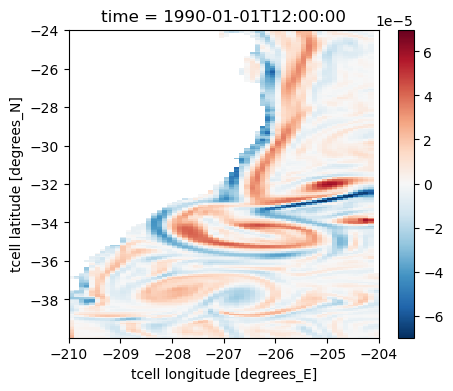

In [25]:
plt.figure(figsize=(5,4))
zeta_xgcm.isel(time=1).plot()

Right, so now that I can calculate both EKE and relative vorticity, let's plot these next to each other and make it Interactive...

In [26]:
maxvalue = 8e-5

In [44]:
def plot_eac_eke(i):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
    
    # ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))
    EKE_om2.isel(time=i).plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=0, vmax=0.6)
    ax1.add_feature(cfeature.LAND)
    ax1.coastlines()
    ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    zeta_xgcm.isel(time=i).plot.contour(ax=ax2, transform=ccrs.PlateCarree(), vmin=-maxvalue, vmax=maxvalue, cmap=cm.cm.balance)
    ax2.add_feature(cfeature.LAND)
    ax2.coastlines()
    ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')

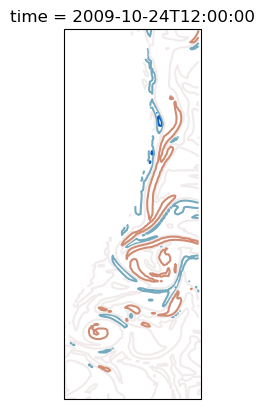

In [43]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
zeta_xgcm.isel(time=7238).plot.contour(transform=ccrs.PlateCarree(), vmin=-maxvalue, vmax=maxvalue, cmap=cm.cm.balance)


In [45]:
interact(plot_eac_eke, i=(0, len(EKE_om2.time),1))

interactive(children=(IntSlider(value=5478, description='i', max=10957), Output()), _dom_classes=('widget-inte…

<function __main__.plot_eac_eke(i)>

What I'd like to do now is - have a third plot of temperature shading and streamlines for the velocity...

### Temperature and velocity streamlines

In [46]:
%%time
# Load in the temperature data from ACCESS
om2_iaf, _ = open_iaf_global(input_vars=['temp'],
                             first_year=1990, last_year=2020,
                            decode_times=True)
om2_iaf

CPU times: user 6.44 s, sys: 2.2 s, total: 8.64 s
Wall time: 13.8 s


<xarray.Dataset>
Dimensions:         (xt_ocean: 3600, yt_ocean: 2700, st_ocean: 75,
                     st_edges_ocean: 76, time: 10957, nv: 2)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    temp            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(31, 75, 300, 300), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    time_bnds       (time, nv) timedelta64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-3d-temp-1-daily-mean-ym_1990_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221019T1326Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [51]:
# Subset down to eddy box
om2_temp = om2_iaf['temp'].sel(xt_ocean=slice(eddy_idx['W'], eddy_idx['E']),
                               yt_ocean=slice(eddy_idx['S'], eddy_idx['N'])).sel(st_ocean=30, method='nearest').chunk({'xt_ocean':-1, 'yt_ocean':-1})
om2_temp

<xarray.DataArray 'temp' (time: 10957, yt_ocean: 190, xt_ocean: 60)>
dask.array<rechunk-merge, shape=(10957, 190, 60), dtype=float32, chunksize=(31, 190, 60), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -204.2 -204.1 -204.0
  * yt_ocean  (yt_ocean) float64 -39.95 -39.88 -39.8 ... -24.2 -24.11 -24.01
    st_ocean  float64 29.45
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_conservative_temperature

In [52]:
%%time
om2_temp = om2_temp.compute()

CPU times: user 25.6 s, sys: 13 s, total: 38.6 s
Wall time: 3min 10s


In [53]:
om2_temp.to_netcdf('/g/data/v45/jr5971/notebooks/data/temp_om2_z30.nc')

In [23]:
%%time
om2_temp = xr.open_dataarray('/g/data/v45/jr5971/notebooks/data/temp_om2_z30.nc')
# om2_temp = om2_temp - 273.15
# om2_temp.to_netcdf('/g/data/v45/jr5971/notebooks/data/temp_om2_z30_tmp.nc')

CPU times: user 25.7 ms, sys: 11.5 ms, total: 37.3 ms
Wall time: 39.9 ms


In [22]:
subprocess.run(['mv' ,'temp_om2_z30_tmp.nc','temp_om2_z30.nc'], cwd='/g/data/v45/jr5971/notebooks/data/')

CompletedProcess(args=['mv', 'temp_om2_z30_tmp.nc', 'temp_om2_z30.nc'], returncode=0)

In [15]:
om2_temp.nbytes/1e9

0.4996392

#### Prepare data for streamplot
Here, it should be a lot easier to prepare the velocity data for ACCESS on the B-Grid compared to MOM6 on the C-grid. 

In [24]:
import xesmf

In [26]:
# define resolution of new target grid
res = 1 # 2 equals half the resolution of native grid
# Rename coords to lon/lat
u = u.rename({'xu_ocean':'lon', 'yu_ocean':'lat'})
v = v.rename({'xu_ocean':'lon', 'yu_ocean':'lat'})

# Create target grid with equal spaced points
x_target = np.linspace(u['lon'].min(), u['lon'].max(), int(len(u['lon']) / res))
y_target = np.linspace(u['lat'].min(), u['lat'].max(), int(len(u['lat']) / res))
X_target, Y_target = np.meshgrid(x_target, y_target)

# Create regridder object
regridder = xesmf.Regridder(u, {'lon':X_target, 'lat':Y_target}, 'bilinear')

# regrid data
u_target = regridder(u)
v_target = regridder(v)

In [ ]:
# Regrid temperature to be plotted
# om2_temp = om2_temp.rename({'xt_ocean':'lon', 'yt_ocean':'lat'})
# x_t = np.linspace(om2_temp['lon'].min(), om2_temp['lon'].max(), 
#                   int(len(om2_temp['lon'])/2))
# y_t = np.linspace(om2_temp['lat'].min(), om2_temp['lat'].max(),
#                   int(len(om2_temp['lat'])/2))
# X_t, Y_t = np.meshgrid(x_t, y_t)


In [71]:
print(f'x_target shape: {x_target.shape}')
print(f'u shape: {u.shape}')

x_target shape: (30,)
u shape: (10957, 190, 60)


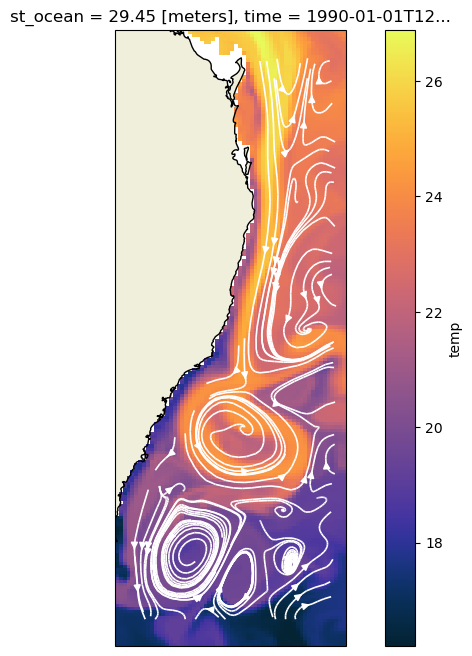

In [27]:
# Plot temperature and streamlines
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
om2_temp.isel(time=0).plot(ax=ax, cmap=cm.cm.thermal, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.streamplot(x_target, y_target, u_target.isel(time=0), v_target.isel(time=0), density=.8, color='w', transform=ccrs.PlateCarree(), 
              linewidth=1.2, broken_streamlines=False)
ax.coastlines()

In [69]:
# define resolution of new target grid
res = 1 # 2 equals half the resolution of native grid
time = '1992-12-07'

# Rename coords to lon/lat
u = u.rename({'xu_ocean':'lon', 'yu_ocean':'lat'})
v = v.rename({'xu_ocean':'lon', 'yu_ocean':'lat'})

# Create target grid with equal spaced points
x_target = np.linspace(u['lon'].min(), u['lon'].max(), int(len(u['lon']) / res))
y_target = np.linspace(u['lat'].min(), u['lat'].max(), int(len(u['lat']) / res))
X_target, Y_target = np.meshgrid(x_target, y_target)

# Create regridder object
regridder = xesmf.Regridder(u.isel(time=0), {'lon':X_target, 'lat':Y_target}, 'bilinear')

# regrid data
u_target = regridder(u.sel(time=time))
v_target = regridder(v.sel(time=time))

In [70]:
# Regrid zeta to shade the vectors
zeta_xgcm_renamed = zeta_xgcm.rename({'yt_ocean':'lat', 'xt_ocean':'lon'}).sel(time=time)
x_t = np.linspace(zeta_xgcm_renamed['lon'].min(), zeta_xgcm_renamed['lon'].max(),
                  int(len(zeta_xgcm_renamed['lon'])/res))
y_t = np.linspace(zeta_xgcm_renamed['lat'].min(), zeta_xgcm_renamed['lat'].max(),
                  int(len(zeta_xgcm_renamed['lat'])/res))
X_t, Y_t = np.meshgrid(x_t, y_t)
regridder = xesmf.Regridder(zeta_xgcm_renamed, {'lon':X_t, 'lat':Y_t}, 'bilinear')
zeta_xgcm_regridded = regridder(zeta_xgcm_renamed)
zeta_xgcm_regridded

<xarray.DataArray (time: 1, y: 190, x: 60)>
array([[[ 5.9031013e-06,  6.6561583e-06,  7.3519877e-06, ...,
         -6.6463385e-06, -6.8948630e-06,  1.1468480e-06],
        [ 6.2905588e-06,  1.0573092e-05,  1.1518544e-05, ...,
         -1.0042513e-05, -9.5621153e-06, -1.8967418e-06],
        [ 4.4288950e-06,  1.0638960e-05,  1.1629907e-05, ...,
         -3.5564058e-06, -5.2691039e-06, -2.7587055e-06],
        ...,
        [           nan,            nan,            nan, ...,
          3.0153140e-05,  2.2173165e-06,            nan],
        [           nan,            nan,            nan, ...,
          3.1320305e-05,  1.5650699e-05,            nan],
        [           nan,            nan,            nan, ...,
          3.2671353e-05,  2.4745501e-05,            nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-12-07T12:00:00
    lat      (y, x) float64 -39.95 -39.95 -39.95 -39.95 ... -24.01 -24.01 -24.01
    lon      (y, x) float64 -209.9 -209.8 -209.7 -209.6 ... -204.2 -204.1 -204.0
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [113]:
print(f'x_target shape: {x_target.shape}')
print(f'u_target shape: {u_target.shape}')
print(f'zeta_target shape: {zeta_xgcm_regridded.shape}')

x_target shape: (30,)
u_target shape: (1, 95, 30)
zeta_target shape: (1, 95, 30)


In [66]:
u_target.time

<xarray.DataArray 'time' (time: 1)>
array(['1992-12-07T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    st_ocean  float64 ...
  * time      (time) datetime64[ns] 1992-12-07T12:00:00

In [ ]:
# Plot temperature and streamlines
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})
zeta_xgcm_regridded.sel(time=time).plot(ax=ax, cmap=cm.cm.balance, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.streamplot(x_target, y_target, u_target.squeeze(), v_target.squeeze(), density=.5,transform=ccrs.PlateCarree(), 
              linewidth=1, broken_streamlines=False)
ax.coastlines()

In [26]:
maxvalue = 8e-5

In [140]:
def plot_eac_eke(i):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=170)})

    # ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=170))
    EKE_om2.isel(time=i).plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=0, vmax=0.6)
    ax1.add_feature(cfeature.LAND)
    ax1.coastlines()
    ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    ax1.set_title(f'EKE, Time: {str(EKE_om2.isel(time=i).time.values)[:10]}')
    zeta_xgcm.isel(time=i).plot.contour(ax=ax2, transform=ccrs.PlateCarree(), vmin=-maxvalue, vmax=maxvalue, cmap=cm.cm.balance)
    ax2.add_feature(cfeature.LAND)
    ax2.coastlines()
    ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    ax2.set_title(f'$\zeta$, Time: {str(zeta_xgcm.isel(time=i).time.values)[:10]}')

    om2_temp.isel(time=i).plot(ax=ax3, transform=ccrs.PlateCarree(), cmap=cm.cm.thermal)
    ax3.add_feature(cfeature.LAND)
    ax3.coastlines()
    ax3.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    ax3.set_title(f'Temp, Time: {str(om2_temp.isel(time=i).time.values)[:10]}')


In [142]:
interact(plot_eac_eke, i=(0, len(EKE_om2.time),1))

interactive(children=(IntSlider(value=5478, description='i', max=10957), Output()), _dom_classes=('widget-inte…

<function __main__.plot_eac_eke(i)>

Could we possibly add some MHW information to the above plot?

Plot when given cells are under MHW conditions? For that, we'd need to run a MHW analysis over a depth of say 30m (Below the Ekman Layer).

That could be quite cool actually.

Okay, so this is pretty cool what I'm seeing above. The relative vorticity adds some value in terms of understanding the rotational shear in the current. 

### 2. MOM6 EKE Calcs
Here, we have to do a bit more prep to regrid one velocity onto the other velocities grid...

#### 2.1 STHPAC-01
Note that the below code will change as we are now subsetting on Setonix and moving over the smaller amount of data so we don't need to do any spatial subsetting here.

In [ ]:
### for STHPAC
u_files = get_mom6_files(years='all', input_vars=['u'])
v_files = get_mom6_files(years='all', input_vars=['v'])
u = xr.open_mfdataset(u_files)['uo']
v = xr.open_mfdataset(v_files)['vo']
vel = xr.merge([u,v])
vel

**Using xgcm**

In [ ]:
# Check for symmetry in the native c-grid
corner = [np.round(vel.xq.min().values,2), np.round(vel.yq.min().values,2)]
centre = [np.round(vel.xh.min().values,2), np.round(vel.yh.min().values,2)]

if corner[0] < centre[0]:
    print(f'Native C-grid is symmetric - most south-western point is a corner.\nMight need to drop this corner point?')
else:
    print(f'Native C-grid is antisymmetric - most south-western point is a centre.')

In [ ]:
# If grids are symmetric, drop corner point


In [ ]:
def make_grid_antisymmetric(da):
    '''
    Checks if native MOM6 grid is symmetric or antisymmetric. 
    XGCM requires grid to be antisymmetric - i.e., left-most col and
    bottom-row to be a centre point
    '''
    corner = [np.round(da.xq.min().values,2), np.round(da.yq.min().values,2)]
    centre = [np.round(da.xh.min().values,2), np.round(da.yh.min().values,2)]
    # Check if grid is symmetric
    if corner[0] < centre[0]:
        print(f'Native C-grid is symmetric - most south-western point is a corner.\nDropping left-col/bottom-row')
        da = da.isel(xq=slice(1,len(da.xq)))
        da = da.isel(yq=slice(1,len(da.yq)))
    else:
        print(f'Native C-grid is antisymmetric - most south-western point is a centre.')
    return da

In [ ]:
vel = make_grid_antisymmetric(vel)